# Flow:
1. Build a Model.
2. Define Function to take input image and predict.


In [3]:
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

# Get Data from TF API:

In [4]:
import pathlib      # treat plain strings as paths
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)       # load contents into dir

228813984/228813984 [==============================] - 1s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


/root/.keras/datasets/flower_photos/roses/5497730366_44d758d8f5.jpg


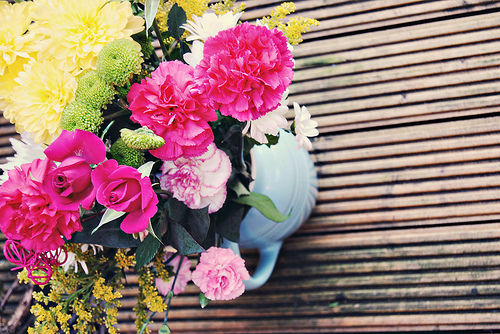

In [6]:
import PIL
roses = list(data_dir.glob('roses/*'))      # category
print(roses[0])

temp_image = PIL.Image.open(roses[0])
temp_image
# w, h = temp_image.size
# print(w, h)

# Generating Training and Validation data:

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_height, img_width = 180, 180
train_ds = image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=32)
val_ds = image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [9]:
len(train_ds)           # make DF by dividing whole dataset into batches

92

In [10]:
len(val_ds)

23

Now, this train_ds and val_ds are batchdataset Object in Tensorflow which return images and labels.

# Visualize Dataset:

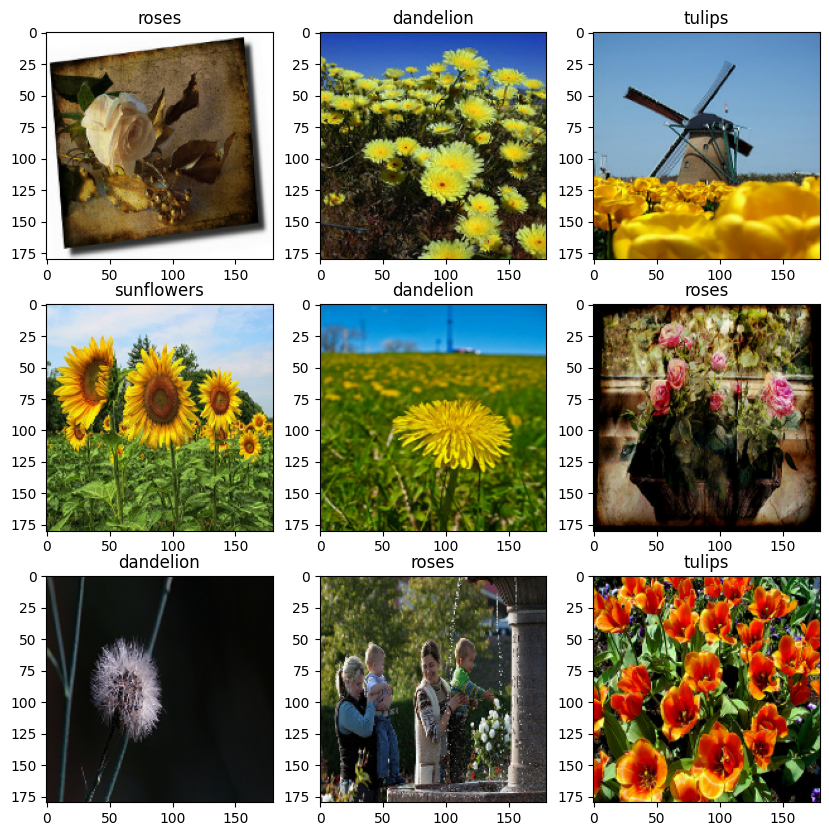

In [11]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))       # imshow works with pixeled array only
        plt.title(class_names[labels[i]])
        # plt.axis("off")

# CNN - 64%:

In [12]:
num_classes = len(class_names)

model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # flatten all 2d,3d into 1d:
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=num_classes, activation='softmax')
])

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 114s 1s/step - loss: 1.3755 - accuracy: 0.4128 - val_loss: 1.1648 - val_accuracy: 0.5150
Epoch 2/10
92/92 [==============================] - 112s 1s/step - loss: 0.9212 - accuracy: 0.6410 - val_loss: 0.9302 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 117s 1s/step - loss: 0.7070 - accuracy: 0.7377 - val_loss: 0.9538 - val_accuracy: 0.6240
Epoch 5/10
92/92 [==============================] - 110s 1s/step - loss: 0.5385 - accuracy: 0.8018 - val_loss: 1.0650 - val_accuracy: 0.6322
Epoch 6/10
92/92 [==============================] - 110s 1s/step - loss: 0.3176 - accuracy: 0.8835 - val_loss: 1.3910 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 110s 1s/step - loss: 0.1898 - accuracy: 0.9407 - val_loss: 1.6338 - val_accuracy: 0.6213
Epoch 8/10
92/92 [==============================] - 109s 1s/step - loss: 0.1232 - accuracy: 0.9615 - val_loss: 1.7728 - val_accuracy: 0.6226
Epoch 9/10
92

# Pre Trained Model - 78 %:
Inceptionv3

In [15]:
epochs= 10
from tensorflow.keras.applications import InceptionV3
model1= Sequential()

pretrained_model= InceptionV3(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
print(len(pretrained_model.layers))

for layer in pretrained_model.layers:
        layer.trainable=False
model1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model1.add(pretrained_model)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(num_classes,activation='softmax'))

87910968/87910968 [==============================] - 1s 0us/step
312


In [16]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model1.fit(
  train_ds,
  validation_data=val_ds,
  steps_per_epoch=5,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 43s 9s/step - loss: 1.5738 - accuracy: 0.2875 - val_loss: 1.0591 - val_accuracy: 0.5858
Epoch 2/10
5/5 [==============================] - 48s 12s/step - loss: 1.1049 - accuracy: 0.5688 - val_loss: 1.0051 - val_accuracy: 0.6308
Epoch 3/10
5/5 [==============================] - 37s 9s/step - loss: 1.0661 - accuracy: 0.5875 - val_loss: 0.9010 - val_accuracy: 0.6526
Epoch 4/10
5/5 [==============================] - 48s 12s/step - loss: 0.7580 - accuracy: 0.6938 - val_loss: 0.7235 - val_accuracy: 0.7452
Epoch 5/10
5/5 [==============================] - 48s 12s/step - loss: 0.7514 - accuracy: 0.7188 - val_loss: 0.6216 - val_accuracy: 0.7616
Epoch 6/10
5/5 [==============================] - 48s 12s/step - loss: 0.5175 - accuracy: 0.8188 - val_loss: 0.5794 - val_accuracy: 0.7875
Epoch 7/10
5/5 [==============================] - 37s 9s/step - loss: 0.5326 - accuracy: 0.8188 - val_loss: 0.6196 - val_accuracy: 0.7807
Epoch 8/10
5/5 [=========================

# Save Model:

In [18]:
from keras.models import load_model
model.save("cnn.h5")
model1.save("inception.h5")
loaded_model = load_model("cnn.h5")
# loss, accuracy = loaded_model.evaluate(test_data, test_targets)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
